In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import LeaveOneOut

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from mordred import Calculator, descriptors

from tqdm import tqdm

random_seed = 103

# Load and prepare data

In [2]:
df = pd.read_csv('../data/combined_data.csv', sep=';')

In [3]:
# Get the number of carbon atoms
df['Mol'] = df.smiles.apply(Chem.MolFromSmiles)
df["atom_count"] = df["Mol"].apply(
    lambda mol: len([atom for atom in mol.GetAtoms() if atom.GetSymbol() == "C"])
)

In [4]:
# Replace fluorine atoms with hydrogen
def replace_f_with_h(mol):
    mol = Chem.RWMol(mol)
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == "F":
            atom.SetAtomicNum(1)
    return mol.GetMol()
df["Mol"] = df["Mol"].apply(replace_f_with_h)
df["new_formula"] = df["Mol"].apply(rdMolDescriptors.CalcMolFormula)

In [4]:
df.head(2)

,name,smiles,InChIKey,molecular_formula,boiling_point,Mol,atom_count
0,"1,1,1,2,2,3,4,5,5,6,6,6-dodecafluoro-3,4-bis(t...",C(C(C(C(F)(F)F)(F)F)(C(F)(F)F)F)(C(C(F)(F)F)(F...,AILNJPONTDNFHN-UHFFFAOYSA-N,C8F18,103.75,<rdkit.Chem.rdchem.Mol object at 0x00000285E88...,8
1,"1,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11...",C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(...,AQPUCGPFMVEJGS-UHFFFAOYSA-N,C16F34,239.00,<rdkit.Chem.rdchem.Mol object at 0x00000285E88...,16


In [5]:
def is_linear_chain(mol):
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            carbon_neighbors = sum(1 for nbr in atom.GetNeighbors() if nbr.GetAtomicNum() == 6)
            if carbon_neighbors > 2:
                return False
    return True

df_chains = df[df['Mol'].apply(is_linear_chain)].copy()
df_branched = df[~df['Mol'].apply(is_linear_chain)].copy()

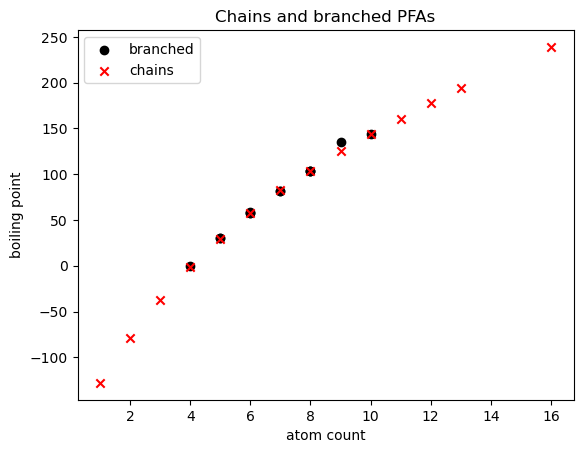

In [6]:
plt.scatter(df_branched.atom_count, df_branched.boiling_point, color='black', label='branched', marker='o')
plt.scatter(df_chains.atom_count, df_chains.boiling_point, color='red', label='chains', marker='x')
plt.xlabel("atom count")
plt.ylabel("boiling point")
plt.title("Chains and branched PFAs")
plt.legend()
plt.show()

# Linear regression for different descriptors

In [25]:
def evaluate_descriptor_LR(descriptor, df):
    X = df[[descriptor]]
    y = df['boiling_point']
    
    loo = LeaveOneOut()
    model = LinearRegression()
    
    y_true = []
    y_pred = []

    # Perform leave one out cross validation
    for train_idx, test_idx in tqdm(loo.split(X), total=X.shape[0]):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[[test_idx[0]]] 
        y_train =  y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        y_true.append(y_test.values[0])
        y_pred.append(pred[0])

    # Calculate metrics
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Plot the true vs predicted boiling point
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
    
    plt.xlabel("True Boiling Point")
    plt.ylabel("Predicted Boiling Point")
    plt.title(f"True vs predicted BP for {descriptor}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the fitted regression line (trained on the entire dataset)
    model.fit(X, y)

    x_vals = np.linspace(X[descriptor].min(), X[descriptor].max(), 100).reshape(-1, 1)
    x_vals_df = pd.DataFrame(x_vals, columns=[descriptor])
    y_vals = model.predict(x_vals_df)

    plt.figure(figsize=(6, 6))
    plt.scatter(X[descriptor], y, label='True boiling point')
    plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Regression line')

    plt.xlabel(descriptor)
    plt.ylabel("Boiling Point")
    plt.title(f"Regression for {descriptor}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

## Atom count

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:00<00:00, 176.24it/s]


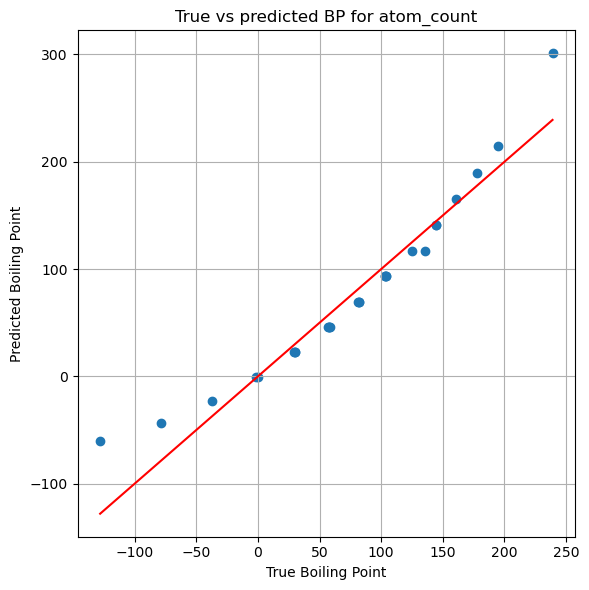

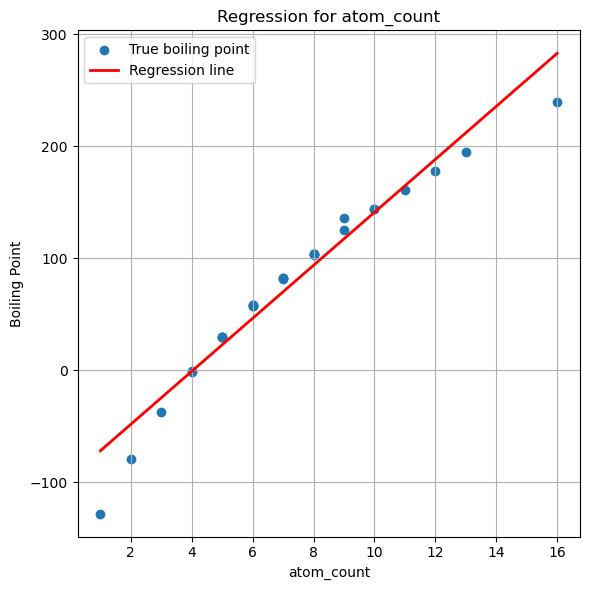

In [9]:
metrics_LR_atom_count = evaluate_descriptor_LR('atom_count', df)

In [8]:
metrics_LR_atom_count

{'rmse': 21.509846356529142,
 'mae': 14.769422316180775,
 'r2': 0.9284382874817457}

## Wiener index

In [10]:
def calculate_Wiener_index(mol):
    dm = Chem.GetDistanceMatrix(mol)
    wi = 0
    for i in range(dm.shape[0]):
        wi += dm[i].sum()
    wi /= 2
    return wi

In [11]:
df['W'] = df.Mol.apply(calculate_Wiener_index)

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 225.53it/s]


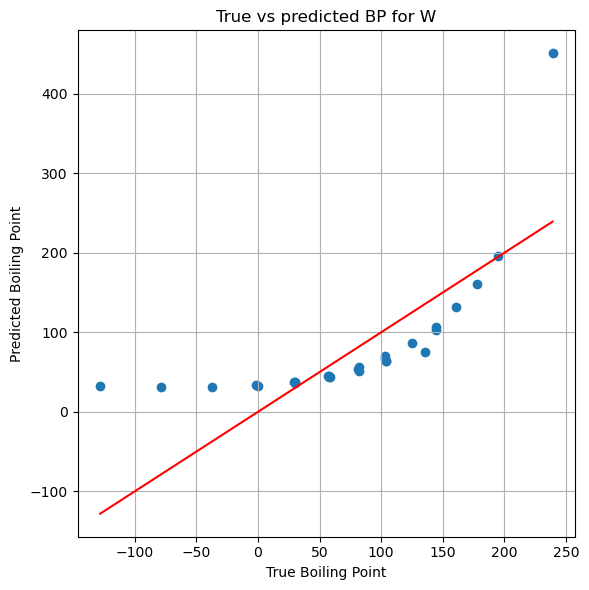

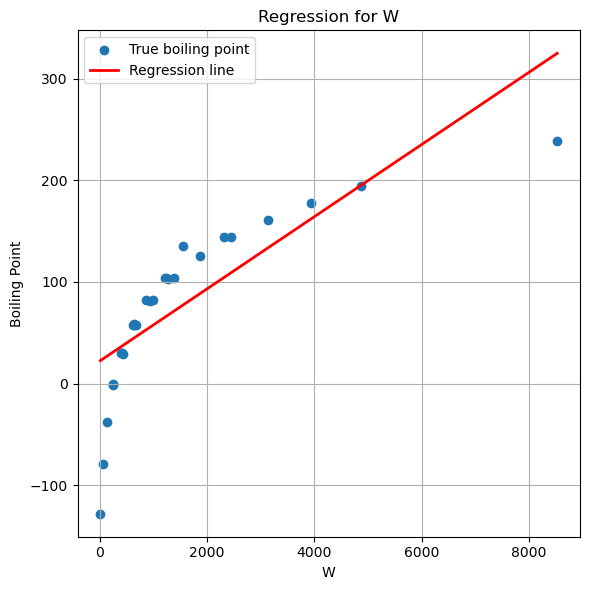

In [12]:
metrics_LR_W = evaluate_descriptor_LR('W', df)

## Zagreb index

In [13]:
def calculate_zagreb_index_1(mol):
    atoms = mol.GetAtoms()
    sum = 0
    for atom in atoms:
        deg = atom.GetDegree()
        sum += deg*deg
    return(sum)

In [14]:
df['M1'] = df.Mol.apply(calculate_zagreb_index_1)

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 211.29it/s]


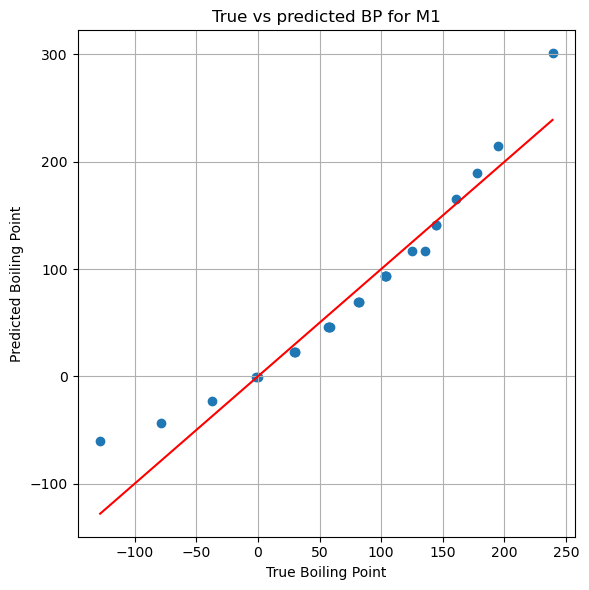

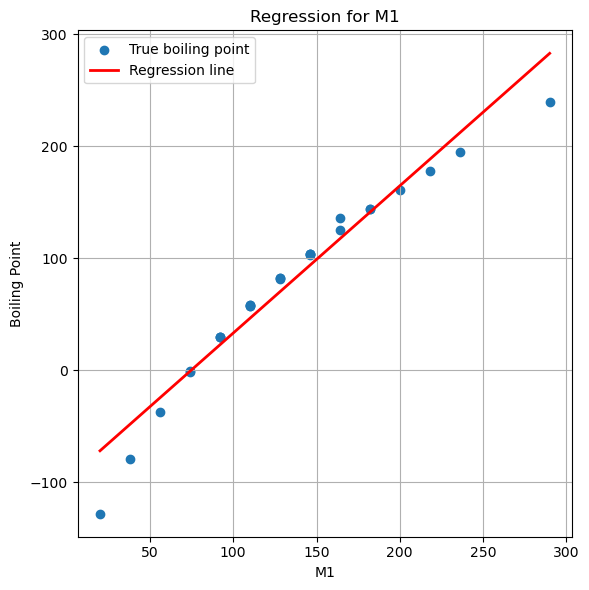

In [15]:
metrics_LR_M1 = evaluate_descriptor_LR('M1', df)

## VE1

In [16]:
calc = Calculator(descriptors.AdjacencyMatrix.AdjacencyMatrix('VE1'))
ve1_results = df['Mol'].apply(lambda mol: calc(mol)[0])
df['VE1_A'] = ve1_results

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 140.51it/s]


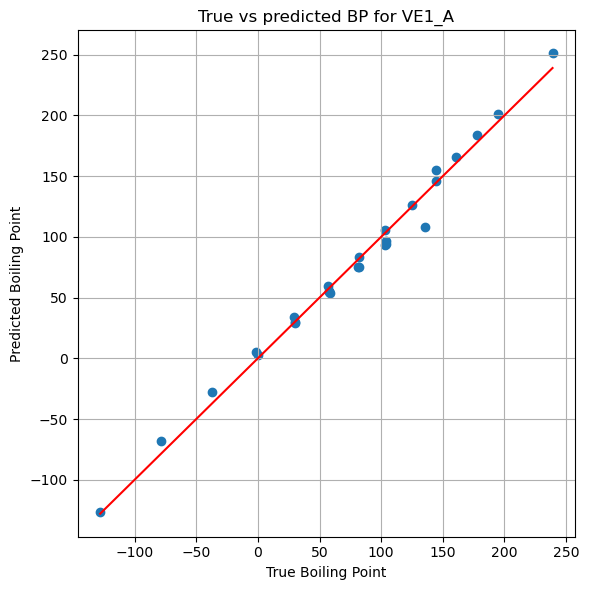

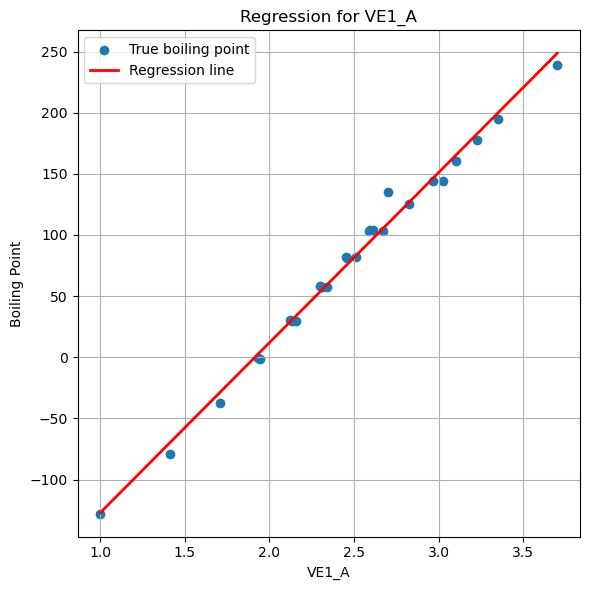

In [17]:
metrics_LR_VE1 = evaluate_descriptor_LR('VE1_A', df)

# Polynomial fits for different descriptors

In [30]:
def evaluate_descriptor_PF(descriptor, df, degree=2, plot=True, show_progress_bar=True):
    X = df[[descriptor]]
    y = df['boiling_point']
    
    loo = LeaveOneOut()
    model = LinearRegression()
    
    y_true = []
    y_pred = []

    # Perform leave one out cross validation
    iterator = loo.split(X)
    if show_progress_bar:
        iterator = tqdm(iterator, total=X.shape[0])

    for train_idx, test_idx in iterator:
        X_train = X.iloc[train_idx]
        X_test = X.iloc[[test_idx[0]]] 
        y_train =  y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        # Transform features for polynomial regression
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        model.fit(X_train_poly, y_train)
        pred = model.predict(X_test_poly)
        
        y_true.append(y_test.values[0])
        y_pred.append(pred[0])

    # Calculate metrics
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if plot:
        # Plot the true vs predicted boiling point
        plt.figure(figsize=(6, 6))
        plt.scatter(y_true, y_pred)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
        
        plt.xlabel("True Boiling Point")
        plt.ylabel("Predicted Boiling Point")
        plt.title(f"True vs predicted BP for {descriptor}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot the fitted polynomial curve (trained on the entire dataset)
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        model.fit(X_poly, y)

        x_vals = np.linspace(X[descriptor].min(), X[descriptor].max(), 100).reshape(-1, 1)
        x_vals_df = pd.DataFrame(x_vals, columns=[descriptor])
        x_vals_poly = poly.transform(x_vals_df)
        y_vals = model.predict(x_vals_poly)

        plt.figure(figsize=(6, 6))
        plt.scatter(X[descriptor], y, label='True boiling point')
        plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Polynomial fit')

        plt.xlabel(descriptor)
        plt.ylabel("Boiling Point")
        plt.title(f"Polynomial Fit for {descriptor}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}


## Atom count

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 140.52it/s]


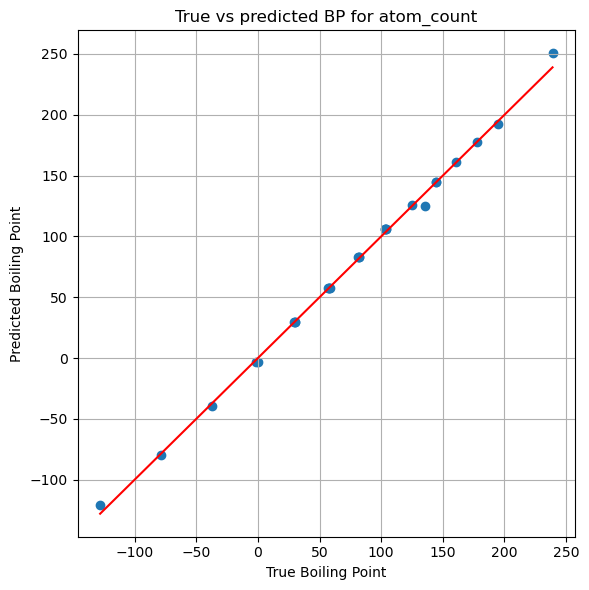

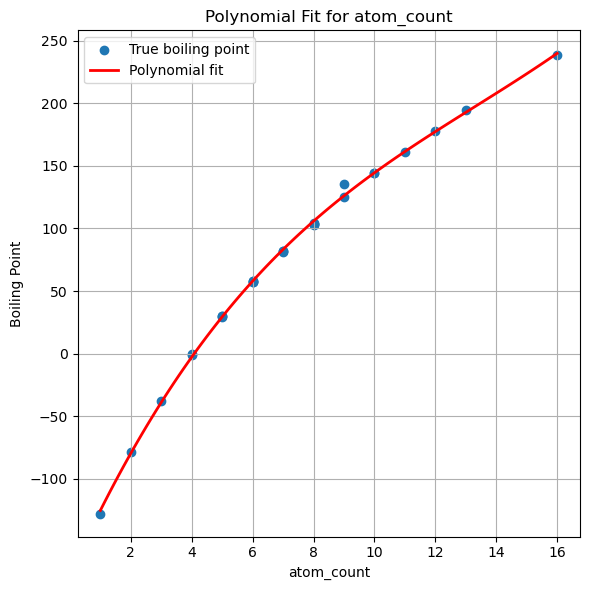

In [19]:
metrics_PF_atom_count = evaluate_descriptor_PF('atom_count', df, degree=3)

## Wiener index

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 144.09it/s]


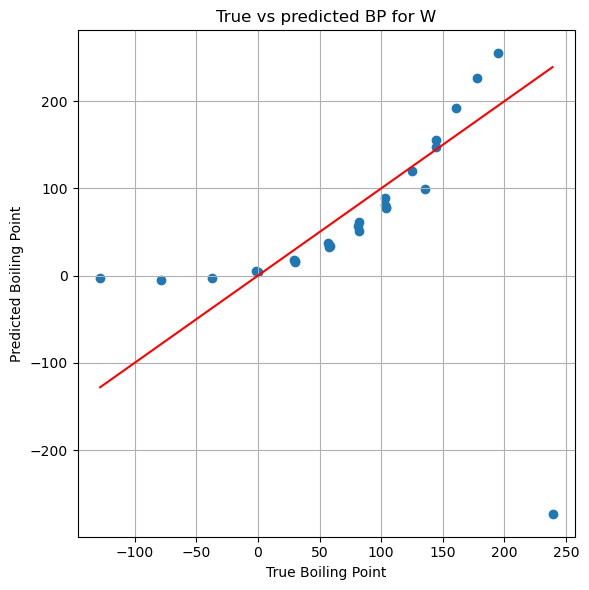

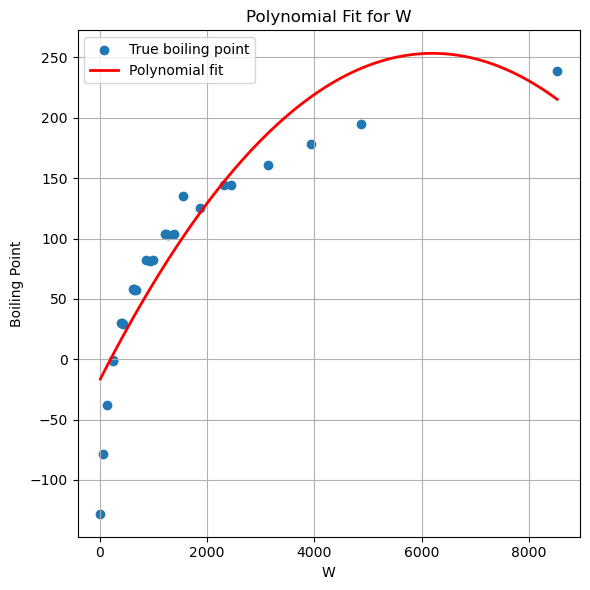

In [20]:
metrics_PF_W = evaluate_descriptor_PF('W', df, degree=2)

## Zagreb index

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 152.85it/s]


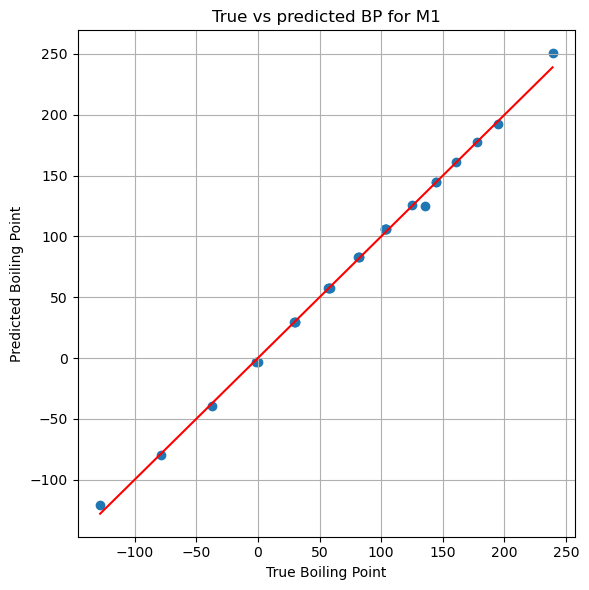

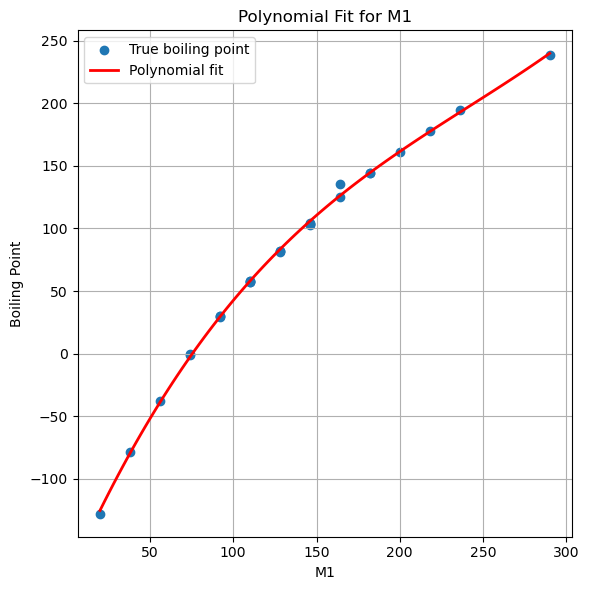

In [21]:
metrics_PF_M1 = evaluate_descriptor_PF('M1', df, degree=3)

## VE1

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 145.77it/s]


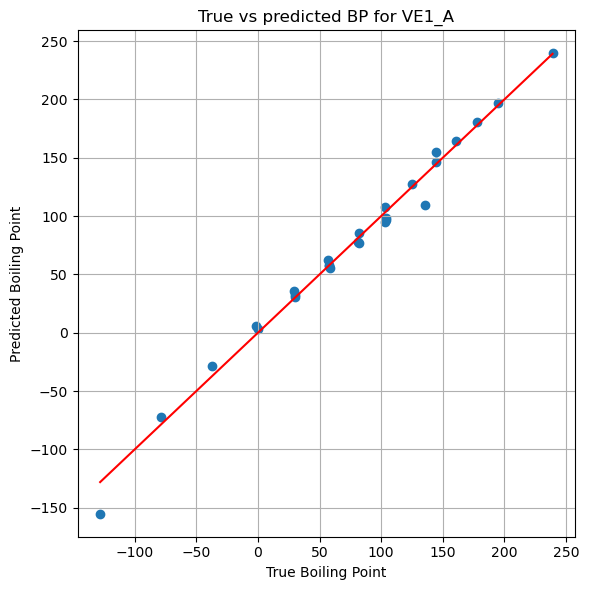

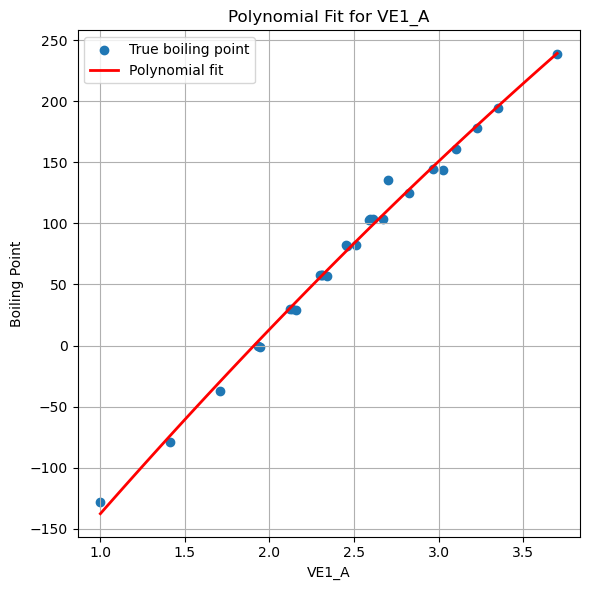

In [22]:
metrics_PF_VE1= evaluate_descriptor_PF('VE1_A', df, degree=2)

# Linear regression on log of descriptors

In [23]:
df['log_atom_count'] = df.atom_count.apply(math.log)
df['log_W'] = df.W.apply(math.log)
df['log_M1'] = df.M1.apply(math.log)
df['log_VE1'] = df.VE1_A.apply(math.log)

## Atom count

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 222.75it/s]


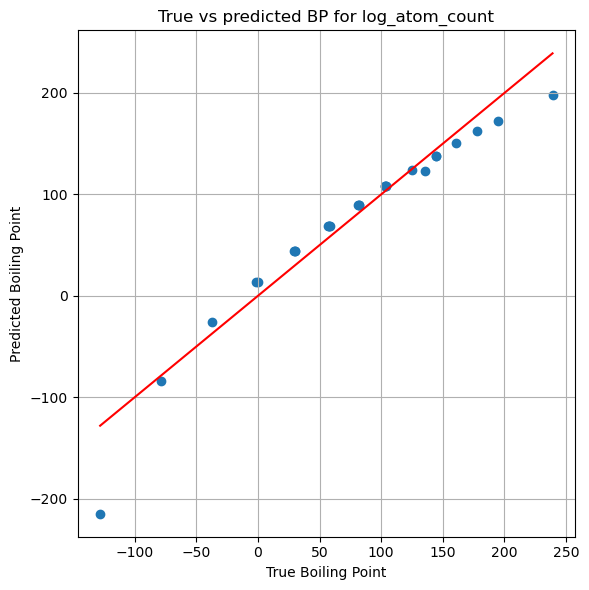

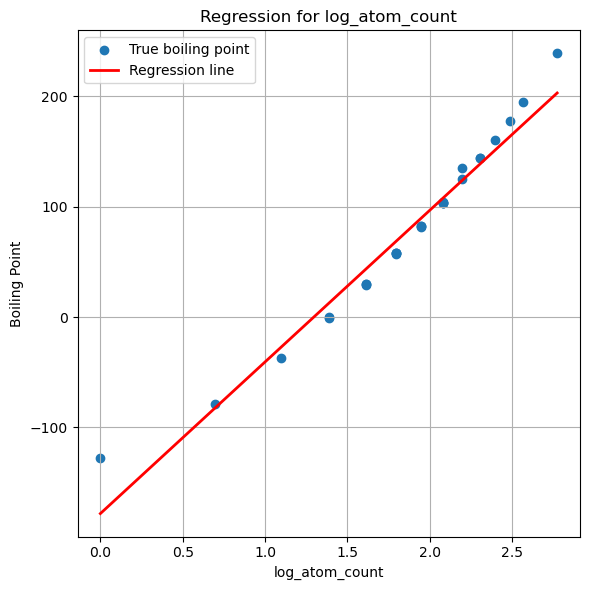

In [24]:
metrics_LR_atom_count_log = evaluate_descriptor_LR('log_atom_count', df)

## Wiener index

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 273.65it/s]


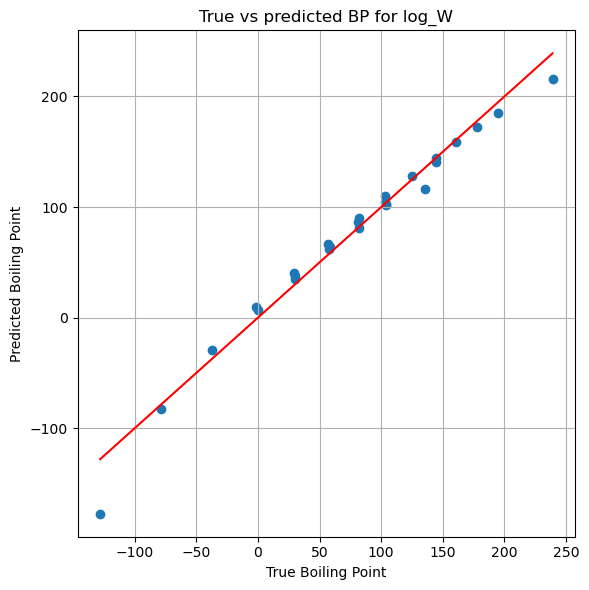

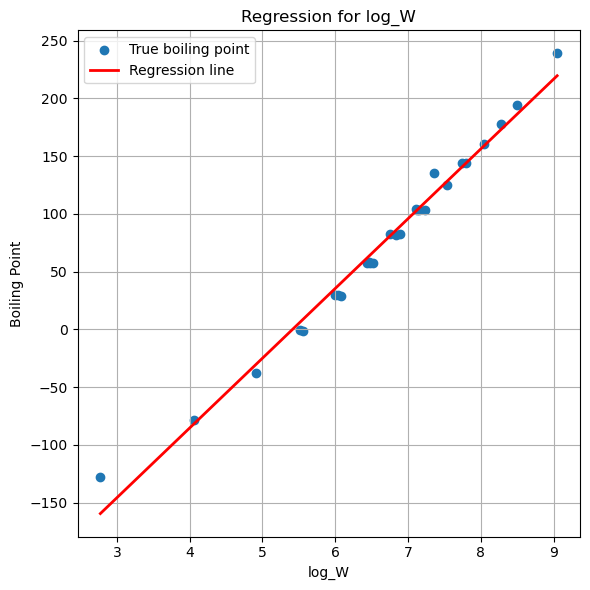

In [25]:
metrics_LR_W_log = evaluate_descriptor_LR('log_W', df)

## Zagreb index

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 222.66it/s]


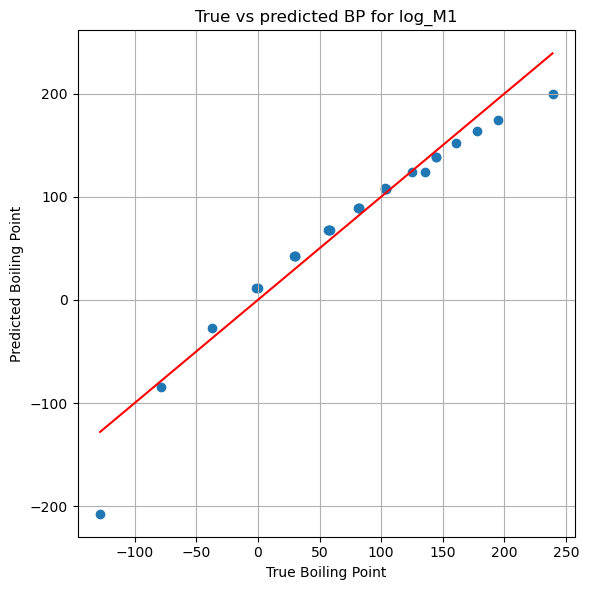

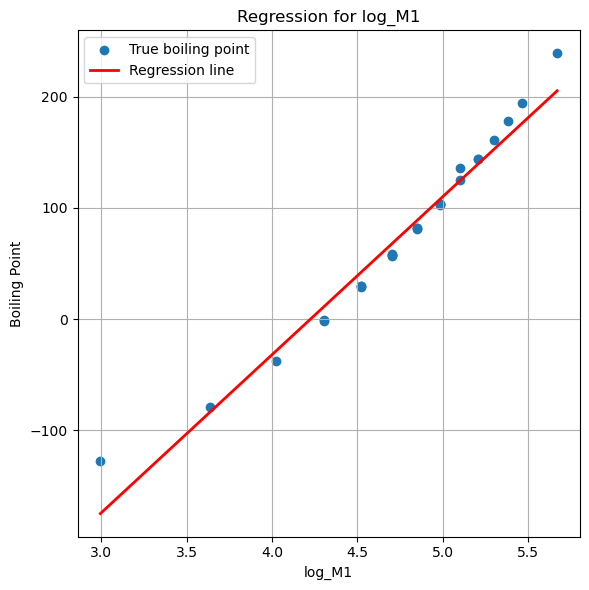

In [26]:
metrics_LR_M1_log = evaluate_descriptor_LR('log_M1', df)

## VE1

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 217.75it/s]


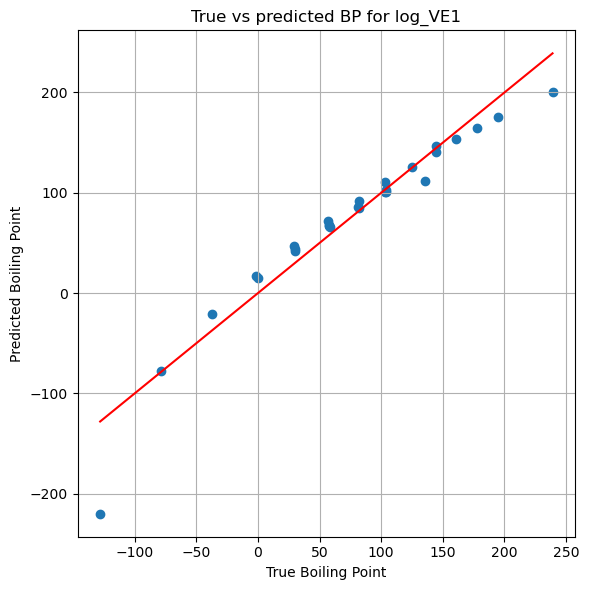

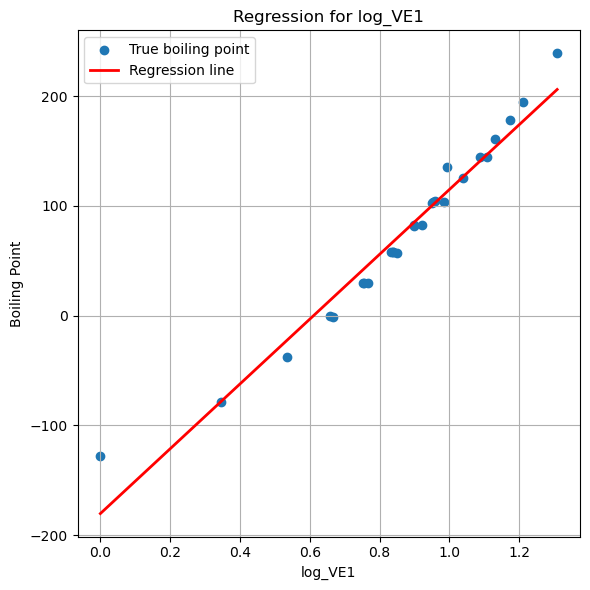

In [27]:
metrics_LR_VE1_log = evaluate_descriptor_LR('log_VE1', df)

# Polynomial fits on log of descriptors

## Atom count

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 222.09it/s]


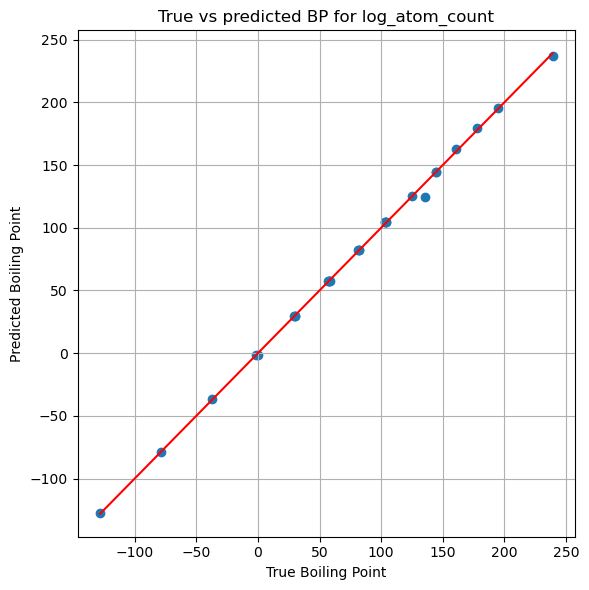

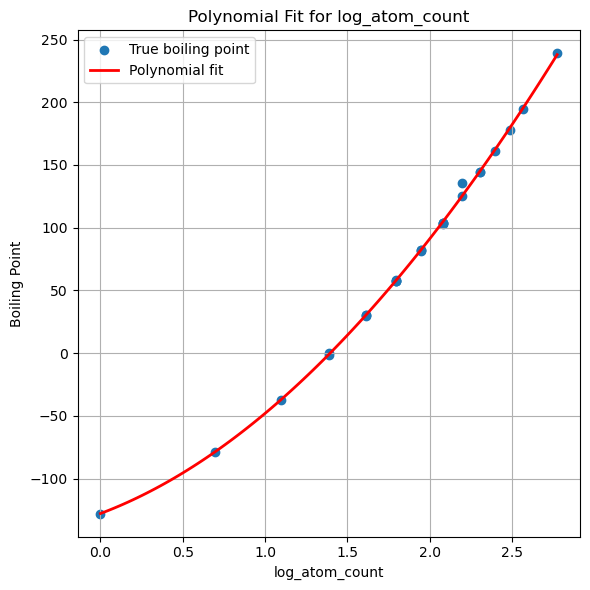

In [33]:
metrics_PF_atom_count_log = evaluate_descriptor_PF('log_atom_count', df, degree=3)

## Wiener index

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 217.29it/s]


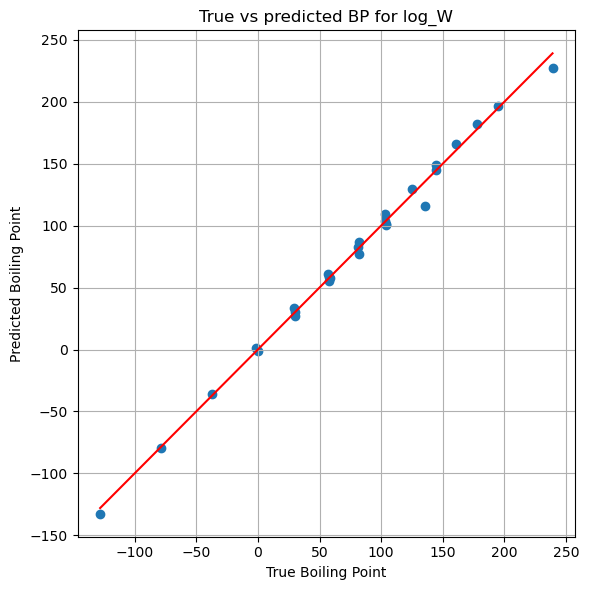

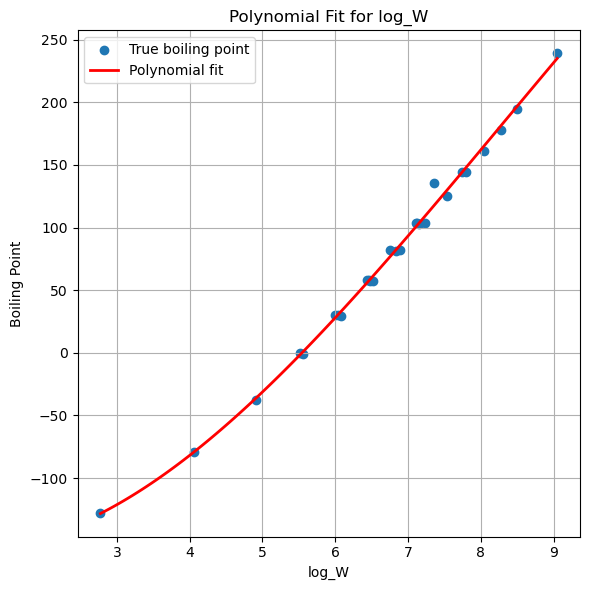

In [36]:
metrics_PF_W_log = evaluate_descriptor_PF('log_W', df, degree=3)

## Zagreb index

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 246.19it/s]


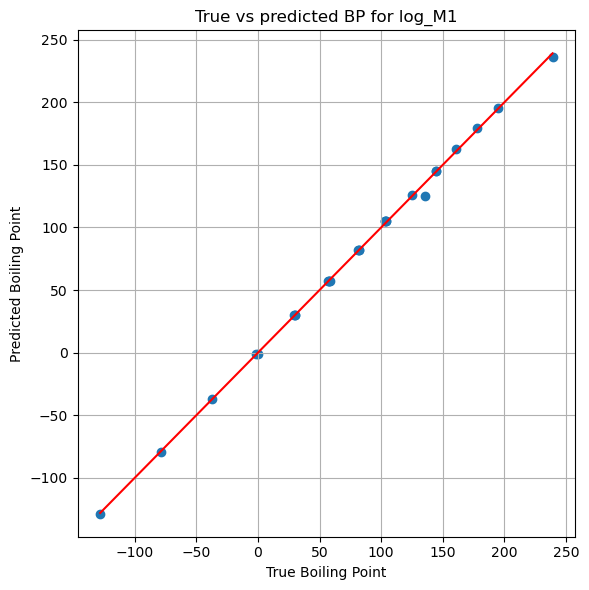

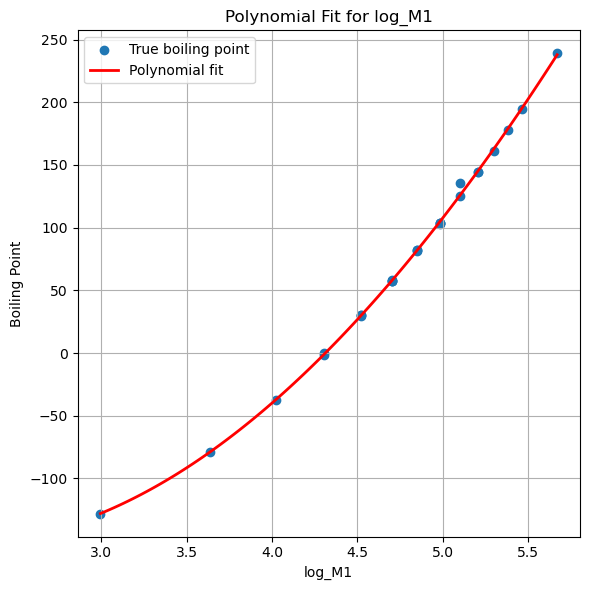

In [40]:
metrics_PF_M1_log = evaluate_descriptor_PF('log_M1', df, degree=3)

## VE1

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 224.63it/s]


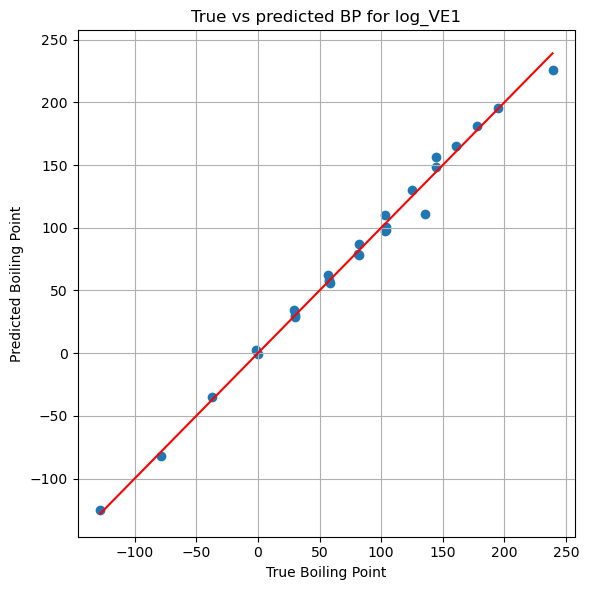

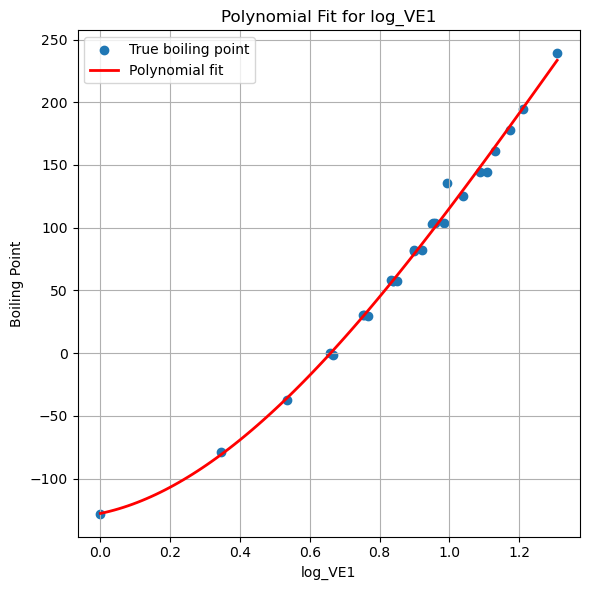

In [41]:
metrics_PF_VE1_log = evaluate_descriptor_PF('log_VE1', df, degree=3)

# Comparison

In [42]:
model_metrics = {
    'Atom count (LR)': {'RMSE': metrics_LR_atom_count['rmse'], 'MAE': metrics_LR_atom_count['mae'], 'R2': metrics_LR_atom_count['r2']},
    'Wiener index (LR)': {'RMSE': metrics_LR_W['rmse'], 'MAE': metrics_LR_W['mae'], 'R2': metrics_LR_W['r2']},
    'Zagreb index (LR)': {'RMSE': metrics_LR_M1['rmse'], 'MAE': metrics_LR_M1['mae'], 'R2': metrics_LR_M1['r2']},
    'VE1 (LR)': {'RMSE': metrics_LR_VE1['rmse'], 'MAE': metrics_LR_VE1['mae'], 'R2': metrics_LR_VE1['r2']},

    'Atom count (PF)': {'RMSE': metrics_PF_atom_count['rmse'], 'MAE': metrics_PF_atom_count['mae'], 'R2': metrics_PF_atom_count['r2']},
    'Wiener index (PF)': {'RMSE': metrics_PF_W['rmse'], 'MAE': metrics_PF_W['mae'], 'R2': metrics_PF_W['r2']},
    'Zagreb index (PF)': {'RMSE': metrics_PF_M1['rmse'], 'MAE': metrics_PF_M1['mae'], 'R2': metrics_PF_M1['r2']},
    'VE1 (PF)': {'RMSE': metrics_PF_VE1['rmse'], 'MAE': metrics_PF_VE1['mae'], 'R2': metrics_PF_VE1['r2']},

    'Atom count (LR, log)': {'RMSE': metrics_LR_atom_count_log['rmse'], 'MAE': metrics_LR_atom_count_log['mae'], 'R2': metrics_LR_atom_count_log['r2']},
    'Wiener index (LR, log)': {'RMSE': metrics_LR_W_log['rmse'], 'MAE': metrics_LR_W_log['mae'], 'R2': metrics_LR_W_log['r2']},
    'Zagreb index (LR, log)': {'RMSE': metrics_LR_M1_log['rmse'], 'MAE': metrics_LR_M1_log['mae'], 'R2': metrics_LR_M1_log['r2']},
    'VE1 (LR, log)': {'RMSE': metrics_LR_VE1_log['rmse'], 'MAE': metrics_LR_VE1_log['mae'], 'R2': metrics_LR_VE1_log['r2']},

    'Atom count (PF, log)': {'RMSE': metrics_PF_atom_count_log['rmse'], 'MAE': metrics_PF_atom_count_log['mae'], 'R2': metrics_PF_atom_count_log['r2']},
    'Wiener index (PF, log)': {'RMSE': metrics_PF_W_log['rmse'], 'MAE': metrics_PF_W_log['mae'], 'R2': metrics_PF_W_log['r2']},
    'Zagreb index (PF, log)': {'RMSE': metrics_PF_M1_log['rmse'], 'MAE': metrics_PF_M1_log['mae'], 'R2': metrics_PF_M1_log['r2']},
    'VE1 (PF, log)': {'RMSE': metrics_PF_VE1_log['rmse'], 'MAE': metrics_PF_VE1_log['mae'], 'R2': metrics_PF_VE1_log['r2']},
}

results_df = pd.DataFrame.from_dict(model_metrics, orient='index')

def highlight_best(df):
    best_rmse = df['RMSE'].min()
    best_mae = df['MAE'].min()
    best_r2 = df['R2'].max()

    highlight = pd.DataFrame('', index=df.index, columns=df.columns)
    highlight.loc[df['RMSE'] == best_rmse, 'RMSE'] = 'background-color: green'
    highlight.loc[df['MAE'] == best_mae, 'MAE'] = 'background-color: green'
    highlight.loc[df['R2'] == best_r2, 'R2'] = 'background-color: green'

    return highlight

styled_results = results_df.style.apply(highlight_best, axis=None)

styled_results


,RMSE,MAE,R2
Atom count (LR),21.509846,14.769422,0.928438
Wiener index (LR),63.189527,42.703017,0.382416
Zagreb index (LR),21.509846,14.769422,0.928438
VE1 (LR),8.141562,6.046237,0.989748
Atom count (PF),3.528530,2.138857,0.998074
Wiener index (PF),105.325329,46.221116,-0.715820
Zagreb index (PF),3.528530,2.138857,0.998074
VE1 (PF),8.693851,5.837551,0.988310
"Atom count (LR, log)",21.233848,13.805231,0.930263
"Wiener index (LR, log)",12.544265,8.074643,0.975661


In [43]:
df.drop(columns=['Mol']).to_csv('../data/combined_data_with_descriptors.csv', sep=';',index=False)

# Test all mordred descriptors

## Calculate descriptors

In [8]:
calc = Calculator(descriptors, ignore_3D=True)
df_desc = (df[['boiling_point', 'Mol']]).copy()

In [9]:
def calculate_descriptors(mol):
    desc_values = calc(mol)
    desc_dict = {}
    
    for d, v in desc_values.items():
        try:
            value = float(v)
            # Check for NaN or infinity (overflow issues)
            if np.isfinite(value):
                desc_dict[str(d)] = value
            else: # Replace with NaN
                desc_dict[str(d)] = np.nan
                
        # Replace errors with NaN
        except (ValueError, OverflowError, TypeError):
            desc_dict[str(d)] = np.nan
    
    return desc_dict

In [12]:
df_desc_calc = df_desc['Mol'].apply(calculate_descriptors).apply(pd.Series)
df_desc = pd.concat([df_desc, df_desc_calc], axis=1)

In [13]:
df_desc.head(2)

,boiling_point,Mol,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,103.75,<rdkit.Chem.rdchem.Mol object at 0x00000285E88...,NaN,NaN,0.0,0.0,25.920744,2.719227,5.438455,25.920744,...,10.957991,62.689261,437.971258,16.845048,1237.0,63.0,146.0,184.0,18.5,4.9375
1,239.00,<rdkit.Chem.rdchem.Mol object at 0x00000285E88...,NaN,NaN,0.0,0.0,51.369087,2.708526,5.417052,51.369087,...,11.664350,90.174736,837.945709,16.758914,8521.0,135.0,290.0,376.0,35.0,9.4375


## Filter NaN and constant descriptors

In [14]:
# Remove descriptors with any NaN values
some_nan_columns = df_desc.columns[df_desc.isna().any()].tolist()
print(len(some_nan_columns))
# print(some_nan_columns)
df_desc = df_desc.drop(columns=some_nan_columns)

482


In [15]:
# Remove constant descriptors
const_cols = [col for col in df_desc.columns if df_desc[col].nunique() == 1]
print(len(const_cols))
# print(const_cols)
df_desc = df_desc.drop(columns=const_cols)

388


In [112]:
df_desc['SMILES'] = df_desc['Mol'].apply(Chem.MolToSmiles)

In [113]:
df_desc.drop(columns=['Mol']).to_csv('../data/combined_data_with_all_descriptors.csv', sep=';',index=False)

## Estimate worthwhile descriptors with Lasso

In [69]:
X = df_desc.drop(columns=['boiling_point', 'Mol'])
y = df_desc['boiling_point']

In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso = Lasso(alpha=1, random_state=random_seed, max_iter=10000)
lasso.fit(X_scaled, y)
selected_descriptors = X.columns[lasso.coef_ != 0]
selected_descriptors

Index(['ATS1dv', 'ATS3d', 'ATS3Z', 'VE1_DzZ', 'VR2_DzZ', 'VE1_Dzm', 'VR2_Dzm',
       'VE1_Dzv', 'VR2_Dzv', 'VR2_Dzse', 'VR2_Dzpe', 'VR2_Dzare', 'VR2_Dzp',
       'VR2_Dzi', 'VR2_D', 'TIC3', 'piPC2', 'TpiPC10'],
      dtype='object')

## Calculate linear regression for all descriptors

In [81]:
def evaluate_descriptor(descriptor, df):
    X = df[descriptor].values.reshape(-1, 1)
    y = df['boiling_point'].values

    loo = LeaveOneOut()
    y_true, y_pred = [], []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        y_true.append(y_test[0])
        y_pred.append(pred[0])

    metrics = {
        'descriptor': descriptor,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

    return metrics

In [85]:
results = [evaluate_descriptor(desc, df_desc) for desc in tqdm(df_desc.drop(columns=['boiling_point', 'Mol']).columns)]

100%|████████████████████████████████████████████████████████████████████████████████| 656/656 [00:11<00:00, 57.38it/s]


In [91]:
sorted_results = sorted(results, key=lambda x: x['MAE'])
sorted_results[:5]

[{'descriptor': 'VE1_DzZ',
  'MAE': 3.155186607156126,
  'RMSE': 4.491402597362255,
  'R2': 0.9968798887452566},
 {'descriptor': 'VE1_Dzm',
  'MAE': 3.155186607156126,
  'RMSE': 4.491402597362255,
  'R2': 0.9968798887452566},
 {'descriptor': 'VE1_Dzv',
  'MAE': 3.155186607156126,
  'RMSE': 4.491402597362255,
  'R2': 0.9968798887452566},
 {'descriptor': 'VE1_Dzse',
  'MAE': 3.155186607156126,
  'RMSE': 4.491402597362255,
  'R2': 0.9968798887452566},
 {'descriptor': 'VE1_Dzpe',
  'MAE': 3.155186607156126,
  'RMSE': 4.491402597362255,
  'R2': 0.9968798887452566}]

## Comparison

In [99]:
def summarize_top_5_models(results):
    sorted_results = sorted(results, key=lambda x: x['MAE'])[:5]

    model_metrics = {
        f"{res['descriptor']}": {
            'RMSE': res['RMSE'],
            'MAE': res['MAE'],
            'R2': res['R2']
        }
        for res in sorted_results
    }

    results_df = pd.DataFrame.from_dict(model_metrics, orient='index')

    styled_results = results_df.style.apply(highlight_best, axis=None)

    return styled_results

display(summarize_top_5_models(results))


,RMSE,MAE,R2
VE1_DzZ,4.491403,3.155187,0.996880
VE1_Dzm,4.491403,3.155187,0.996880
VE1_Dzv,4.491403,3.155187,0.996880
VE1_Dzse,4.491403,3.155187,0.996880
VE1_Dzpe,4.491403,3.155187,0.996880


#### VE1_DzZ
* coefficient sum of the last eigenvector from Barysz matrix weighted by atomic number

# Polynomial fit for all descriptors

In [89]:
def evaluate_descriptor_PF(descriptor, df, degree=2, plot=True, show_progress_bar=True):
    X = df[[descriptor]]
    y = df['boiling_point']
    
    loo = LeaveOneOut()
    model = LinearRegression()
    
    y_true = []
    y_pred = []

    # Perform leave one out cross validation
    iterator = loo.split(X)
    if show_progress_bar:
        iterator = tqdm(iterator, total=X.shape[0])

    for train_idx, test_idx in iterator:
        X_train = X.iloc[train_idx]
        X_test = X.iloc[[test_idx[0]]] 
        y_train =  y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        # Transform features for polynomial regression
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        model.fit(X_train_poly, y_train)
        pred = model.predict(X_test_poly)
        
        y_true.append(y_test.values[0])
        y_pred.append(pred[0])

    # Calculate metrics
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if plot:
        # # Plot the true vs predicted boiling point
        # plt.figure(figsize=(6, 6))
        # plt.scatter(y_true, y_pred)
        # plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
        
        # plt.xlabel("True Boiling Point")
        # plt.ylabel("Predicted Boiling Point")
        # plt.title(f"True vs predicted BP for {descriptor}")
        # plt.grid(True)
        # plt.tight_layout()
        # plt.show()

        # Plot the fitted polynomial curve (trained on the entire dataset)
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        model.fit(X_poly, y)

        x_vals = np.linspace(X[descriptor].min(), X[descriptor].max(), 100).reshape(-1, 1)
        x_vals_df = pd.DataFrame(x_vals, columns=[descriptor])
        x_vals_poly = poly.transform(x_vals_df)
        y_vals = model.predict(x_vals_poly)

        plt.figure(figsize=(6, 6))
        # plt.scatter(X[descriptor], y, label='True boiling point')
        plt.scatter(df_chains[descriptor], df_chains['boiling_point'], label='Linear', color='#4C72B0', alpha=0.7, s=70)
        plt.scatter(df_branched[descriptor], df_branched['boiling_point'], label='Branched', color="#E56317", alpha=1, marker='x', s=90)
        
        plt.plot(x_vals, y_vals, color='#333333', linewidth=2, label='Polynomial fit', alpha=0.7)

        plt.xlabel("ln(carbon count)")
        plt.ylabel("Boiling point (°C)")
        # plt.title(f"Polynomial Fit for {descriptor}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("../img/pfas_chains_branched_ac_pf.svg", format="svg")
        plt.show()

    return {'descriptor': descriptor, 'rmse': rmse, 'mae': mae, 'r2': r2}


In [53]:
df["atom_count"] = df["Mol"].apply(
    lambda mol: len([atom for atom in mol.GetAtoms() if atom.GetSymbol() == "C"])
)

In [61]:
df["log_atom_count"] = df.atom_count.apply(math.log)
df_chains = df[df['Mol'].apply(is_linear_chain)].copy()
df_branched = df[~df['Mol'].apply(is_linear_chain)].copy()

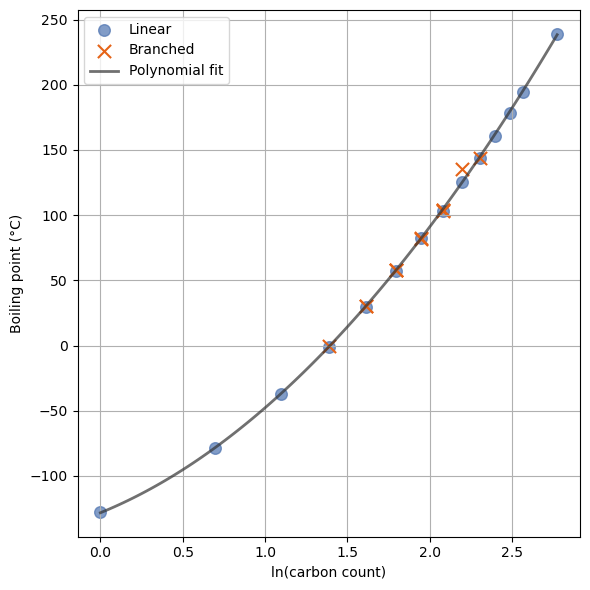

{'descriptor': 'log_atom_count',
 'rmse': 2.2370358251366933,
 'mae': 1.1117382422615942,
 'r2': 0.9992259803489607}

In [90]:
evaluate_descriptor_PF('log_atom_count', df, plot=True, show_progress_bar=False)

In [19]:
evaluate_descriptor_PF('atom_count', df, plot=False, show_progress_bar=False)

{'descriptor': 'atom_count',
 'rmse': 9.417987131632357,
 'mae': 6.068825859836794,
 'r2': 0.9862810051251636}

In [65]:
df_desc['SMILES'] = df_desc['Mol'].apply(Chem.MolToSmiles)

In [66]:
df_desc.head()

,boiling_point,Mol,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2,SMILES
0,103.75,<rdkit.Chem.rdchem.Mol object at 0x0000027B718...,9.331737,2.095294,4.190588,9.331737,1.166467,2.900838,2.595082,0.324385,...,8.103192,34.513363,114.140851,4.390033,68.0,8.0,30.0,31.0,2.111111,[H]C([H])([H])C([H])([H])C([H])(C([H])([H])[H]...
1,239.00,<rdkit.Chem.rdchem.Mol object at 0x0000027B718...,19.675903,1.965946,3.931892,19.675903,1.229744,3.583262,3.701529,0.231346,...,8.089789,44.454249,226.266051,4.525321,680.0,13.0,58.0,56.0,4.250000,[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...
2,144.20,<rdkit.Chem.rdchem.Mol object at 0x0000027B718...,12.053348,1.918986,3.837972,12.053348,1.205335,3.105180,2.965687,0.296569,...,7.466799,35.643477,142.172151,4.442880,165.0,7.0,34.0,32.0,2.750000,[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...
3,-0.30,<rdkit.Chem.rdchem.Mol object at 0x0000027B718...,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,1.931852,0.482963,...,6.188264,24.179697,58.078250,4.148446,9.0,0.0,12.0,9.0,1.000000,[H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H]...
4,81.50,<rdkit.Chem.rdchem.Mol object at 0x0000027B718...,7.878462,1.969616,3.939231,7.878462,1.125495,2.752840,2.458387,0.351198,...,7.486053,31.656710,100.125201,4.353270,50.0,5.0,24.0,23.0,1.916667,[H]C([H])([H])C([H])([H])C([H])([H])C([H])(C([...


In [20]:
df_desc.columns

Index(['boiling_point', 'Mol', 'SpAbs_A', 'SpMax_A', 'SpDiam_A', 'SpAD_A',
       'SpMAD_A', 'LogEE_A', 'VE1_A', 'VE2_A',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=745)

In [21]:
results = [evaluate_descriptor_PF(desc, df_desc, plot=False, show_progress_bar=False) for desc in tqdm(df_desc.drop(columns=['boiling_point', 'Mol']).columns)]

100%|██████████| 743/743 [01:29<00:00,  8.28it/s]


In [22]:
len(results)

743

In [23]:
results_sorted = sorted(results, key=lambda x: x['mae'])

In [24]:
results_sorted

[{'descriptor': 'VR3_Dzp',
  'rmse': 1.9454672818869043,
  'mae': 1.0848962172941345,
  'r2': 0.999414598310821},
 {'descriptor': 'VR3_Dzare',
  'rmse': 2.0581813170415133,
  'mae': 1.0917339430972428,
  'r2': 0.9993448007800925},
 {'descriptor': 'VR3_Dzm',
  'rmse': 2.0615489620026453,
  'mae': 1.0961851300503778,
  'r2': 0.9993426549210477},
 {'descriptor': 'VR3_Dzpe',
  'rmse': 2.06273930178355,
  'mae': 1.0978902177941452,
  'r2': 0.9993418955988979},
 {'descriptor': 'VR3_Dzi',
  'rmse': 2.0634975796823896,
  'mae': 1.098974809615146,
  'r2': 0.9993414116620816},
 {'descriptor': 'VR3_DzZ',
  'rmse': 2.066083778459311,
  'mae': 1.1030006587325536,
  'r2': 0.9993397597990374},
 {'descriptor': 'VR3_Dzse',
  'rmse': 2.0683346326747474,
  'mae': 1.1068713876827985,
  'r2': 0.9993383204441008},
 {'descriptor': 'VR3_Dzv',
  'rmse': 2.0263169564661063,
  'mae': 1.1302099977487263,
  'r2': 0.9993649310701715},
 {'descriptor': 'VR3_D',
  'rmse': 2.07406209983873,
  'mae': 1.1406862404053746,

In [46]:
exclude_cols = ['Mol', 'boiling_point']
cols_to_check = [col for col in df_desc.columns if col not in exclude_cols]
loggable_cols = [col for col in cols_to_check if (df_desc[col] > 0).all()]

In [48]:
df_log = df_desc.copy()
df_log[loggable_cols] = np.log(df_desc[loggable_cols])

In [49]:
results = [evaluate_descriptor_PF(desc, df_log, plot=False, show_progress_bar=False) for desc in tqdm(df_desc.drop(columns=['boiling_point', 'Mol']).columns)]

100%|██████████| 743/743 [01:36<00:00,  7.71it/s]


In [50]:
results_sorted = sorted(results, key=lambda x: x['mae'])
results_sorted[:5]

[{'descriptor': 'ATS2se',
  'rmse': 2.0192886091750184,
  'mae': 1.0943581147619987,
  'r2': 0.999369328944952},
 {'descriptor': 'VR1_Dzare',
  'rmse': 1.9110763889783244,
  'mae': 1.094617818140016,
  'r2': 0.9994351121909693},
 {'descriptor': 'VR1_Dzm',
  'rmse': 1.912711460074745,
  'mae': 1.1034025105576521,
  'r2': 0.9994341451685591},
 {'descriptor': 'VR1_Dzpe',
  'rmse': 1.9133687683913412,
  'mae': 1.1064756806322877,
  'r2': 0.9994337561867354},
 {'descriptor': 'VR1_Dzi',
  'rmse': 1.9138064938136023,
  'mae': 1.108429011699216,
  'r2': 0.9994334970755091}]

# Statistcial comparison

In [92]:
X = df[['log_atom_count']]
y = df['boiling_point']

loo = LeaveOneOut()
model = LinearRegression()

y_true = []
y_pred = []

# Perform leave one out cross validation
iterator = loo.split(X)

for train_idx, test_idx in iterator:
    X_train = X.iloc[train_idx]
    X_test = X.iloc[[test_idx[0]]] 
    y_train =  y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    # Transform features for polynomial regression
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model.fit(X_train_poly, y_train)
    pred = model.predict(X_test_poly)
    
    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# Calculate metrics
rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

In [ ]:
maes1 = abs(np.array(y_true) - np.array(y_pred))
maes

array([ 1.00961338,  0.91634331,  0.52555794,  0.7133794 ,  0.71407245,
        0.09697656,  0.74797727,  0.76240247,  0.38537467,  0.17730992,
        0.053917  ,  0.43935365,  0.76421465, 10.5859708 ,  0.63266039,
        1.7945217 ,  1.04035274,  0.15337601,  1.70462716,  0.16198827,
        2.03415359,  0.17973511,  1.72010597,  1.08377383,  1.32357671,
        0.27559045,  0.02000715])

In [98]:
X = df_desc[['VR3_Dzp']]
y = df_desc['boiling_point']

loo = LeaveOneOut()
model = LinearRegression()

y_true = []
y_pred = []

# Perform leave one out cross validation
iterator = loo.split(X)

for train_idx, test_idx in iterator:
    X_train = X.iloc[train_idx]
    X_test = X.iloc[[test_idx[0]]] 
    y_train =  y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    # Transform features for polynomial regression
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model.fit(X_train_poly, y_train)
    pred = model.predict(X_test_poly)
    
    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# Calculate metrics
rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

In [ ]:
maes2 = abs(np.array(y_true) - np.array(y_pred))
maes2

array([1.76301406, 0.46516258, 0.12833314, 0.69833904, 0.71676897,
       0.42441659, 1.62473871, 0.74629413, 0.07946696, 0.9631628 ,
       0.12969636, 0.06020359, 0.10903741, 8.80689865, 0.55774205,
       2.19276499, 0.90530898, 0.35540408, 1.74666024, 0.56539838,
       1.47868012, 0.58295915, 1.29357674, 0.81677667, 0.551276  ,
       0.47645923, 1.05365824])

In [101]:
from scipy.stats import wilcoxon

In [104]:
statistic, p_value = wilcoxon(maes1, maes2, alternative='greater')
statistic, p_value

(193.0, 0.4670429676771164)